In [126]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import plotly.graph_objs as go
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import json
from torch.utils.data import Dataset
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F

In [127]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# dataset definition
class thyroidDataset(Dataset):
    def __init__(self, split):
        self.all_data = []
        self.split = split
        self.compositions = {'Unknown':0, 'cystic':1,
                             'predominantly solid':2,
                             'solid':3, 'spongiform appareance':4}
        self.echogenicities = {'Unknown':0, 'hyperechogenecity':1,
                             'hypoechogenecity':2, 'isoechogenicity':3,
                             'marked hypoechogenecity':4}
        self.margins = {'Unknown':0, 'ill- defined':1, 'microlobulated':2,
                        'spiculated':3, 'well defined smooth':4}
        self.calcifications = {'macrocalcification':0, 'microcalcification':1, 'non':2}
        self.types ={'benign':0, 'malign':1}
        self.types_count = []
        for t_type in ['benign', 'malign']:
            root_dir=Path('../data/' + split + '/' + t_type).expanduser().resolve().absolute() 
            print(root_dir)
            files = list(root_dir.glob("*"))
            labels = [self.types[t_type]] * len(files)
            self.types_count.append(len(files))
            data_list = list(zip(files, labels))
            self.all_data.extend(data_list)
        random.shuffle(self.all_data)
        self.cases, self.types = zip(*self.all_data)
        print("number of data items:" + str(len(self.cases)))
        self.sample_weights = [1/self.types_count[label] for label in self.types]
    def __len__(self):
        return len(self.cases)
  
    def __getitem__(self, idx):
        labels = np.zeros(16, dtype = float)
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).getroot()
        for x in xml_data:
            if x.tag=='composition' and x.text is not None:
                composition = x.text
                labels[self.compositions[composition] - 1] = 1.0
            if x.tag=='echogenicity' and x.text is not None:
                echogenicity = x.text
                labels[self.echogenicities[echogenicity] + 3] = 1.0
            if x.tag=='margins' and x.text is not None:
                margin = x.text
                labels[self.margins[margin] + 7] = 1.0
            if x.tag=='calcifications' and x.text is not None:
                calcification = x.text
                labels[self.calcifications[calcification] + 11] = 1.0
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).find("mark")
        for x in xml_data:
            if(x.tag=='svg'):
                encoded = str(x.text)
                poly_data = json.loads(x.text)
        
        labels[15] = list(self.types)[idx]
        im_name = list(self.cases[idx].glob('*[0-9].jpg'))[0]
        im = cv2.imread(str(im_name))
        mask = np.zeros(np.shape(im))
        im = cv2.resize(im, dsize=(300, 300), interpolation=cv2.INTER_CUBIC)
        
        # add mask 
        for polygon in poly_data:
            xs = []
            ys = []
            for point in polygon["points"]:
                xs.append(point["x"])
                ys.append(point["y"])
            contour = np.concatenate((np.expand_dims(xs, 1), np.expand_dims(ys, 1)), axis=1)
            cv2.fillPoly(mask, pts = [contour], color =(1, 1, 1))
        
        mask = cv2.resize(mask, dsize=(300, 300), interpolation=cv2.INTER_LINEAR)
        
        #im = im * mask
        
        # Adding data augmentation to avoid overfitting
        if self.split == 'train':
            if random.randint(1, 10) > 5:
                im = np.flipud(im)
                mask = np.flipud(mask)
            if random.randint(1, 10) > 5:
                im = np.fliplr(im)
                mask = np.fliplr(mask)
            if random.randint(1, 10) > 5:
                for i in range(random.randint(1, 4)):
                    im = np.rot90(im)
                    mask = np.rot90(mask)
        im = np.ascontiguousarray(im)
        mask = np.ascontiguousarray(mask)
        #plt.figure()
        #plt.imshow(im)

        transforms = Compose([ToTensor()])
        mask = transforms(mask)
        im = transforms(im)
        mask = mask[0]
        mask = torch.unsqueeze(mask,0)
        #print(mask.shape)
        masked_im = torch.cat((im, mask), 0)
        # masked_im = im * ((mask / 2) + 0.5)
        
        #print(masked_im)
        
        masked_im = masked_im.type(torch.cuda.FloatTensor)
        
        sample = {"image": masked_im, "labels": torch.from_numpy(labels), "types" : self.types, "name": str(im_name)}
        return sample

In [128]:
# Dataset creation
training_set = thyroidDataset(split='train')
parameters_train = {
    "batch_size": 8,
    #"shuffle": True,
}
parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
training_set = thyroidDataset(split='train')
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train, sampler=torch.utils.data.WeightedRandomSampler(training_set.sample_weights, len(training_set.cases), replacement=True))
#training_generator = torch.utils.data.DataLoader(training_set, **parameters_train)
totiter = len(training_generator)
train_data = iter(training_generator).next()

/home/ahana/thyroid/data/train/benign
/home/ahana/thyroid/data/train/malign
number of data items:73
/home/ahana/thyroid/data/train/benign
/home/ahana/thyroid/data/train/malign
number of data items:73


In [129]:
# Model definition and creation

z = 7 # groups
a = 15
k = 5 # top k 
num_labels = 1
num_channels = 4

G = np.random.randn(z, a)
W = np.random.randn(z, num_labels)

# class MutualExclusivityLoss(nn.Module):
#     def __init__(self, num_classes, num_attrs):
#         super(MutualExclusivityLoss, self).__init__()
#         self.num_attrs = num_attrs
#         self.num_classes = num_classes
#     def forward(self, target, result):
#         target = 1.0 - target
#         me_loss = target.mul(result)
#         return torch.mean(me_loss)
        
   

class net(torch.nn.Module):
    
    def __init__(self, G, W):
        super().__init__()
        
        self.conv1 = nn.Conv2d(num_channels, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv5 = nn.Conv2d(128, 256,3)
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        
        self.features = [self.conv1, self.conv2, self.conv3, self.conv4]
        
        # self.fc1 = nn.Linear(14400, 120)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(256, 15)
        
        self.G_ = torch.nn.Parameter(G)
        self.W_ = torch.nn.Parameter(W)
        #self.CNN_ = torch.nn.Parameter(CNN)
        


    def forward(self, x):
            
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x = self.pool(F.tanh(self.conv4(x)))
        # Adding 1 more conv, a GAP and a final linear layer for CAM
        x = F.tanh(self.conv5(x))
        features = x
        x = self.GAP(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = torch.unsqueeze(x, 2)
        
        g = torch.matmul(self.G_, x) 
        
        g = g.repeat((1, 1, num_labels))
        
        y = g * self.W_
        #y, _ = y.max(axis=2)
        
        y = torch.transpose(y, 1, 0)
        
        y = torch.sum(y, axis=0)
        return (torch.sigmoid(y), torch.sigmoid(x), features)

# Model creation and definition of losses
model = net(torch.FloatTensor(G), torch.FloatTensor(W))
model.to(device)

def projection_simplex_sort(v, z=1):

    n_features = v.size(1)
    u,_ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u,1) - z
    ind = torch.arange(n_features).type_as(v) + 1
    cond = u - cssv / ind > 0
    #rho = ind[cond][-1]
    rho,ind_rho = (ind*cond).max(1)
    #theta = cssv[cond][-1] / float(rho)
    theta = torch.gather(cssv,1,ind_rho[:,None]) / rho[:,None]
    w = torch.clamp(v - theta, min=0)
    return w

criterion = torch.nn.BCELoss(reduction='sum')

criterion1 = torch.nn.L1Loss(reduction='sum')

#criterion2 = MutualExclusivityLoss(15, 5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

#y_tr = torch.from_numpy(y_train).to(device)

In [113]:
# Load existing model
model.load_state_dict(torch.load(f'../data/models/end_to_end_v2_CAM_3_weighted_mask.pt'))

<All keys matched successfully>

In [ ]:
# perform training

epoch = 0
for epoch in range(20000):
    running_loss = 0.0
    #model.train()
    for data in training_generator:
        #model.train(True)
        x_im_train = data["image"]
        if(np.shape(x_im_train)[0]==1):
            continue
        y_im_train = data["labels"][:, 15].to(device)
        x_im_train = x_im_train.to(device)
        y_attr = data["labels"][:, :15].to(device)
        optimizer.zero_grad()

        (y_pred, attributes_pred, features) = model(x_im_train)
        
        # this needs work 
        loss = criterion(torch.squeeze(y_pred.to(float)), torch.squeeze(y_im_train.to(float))) + criterion1(torch.squeeze(attributes_pred.to(float)), torch.squeeze(y_attr.to(float))) 
        # + criterion2(torch.squeeze(attributes_pred.to(float)), torch.squeeze(y_attr.to(float)))  
    
        loss.backward()
        optimizer.step()
        model.G_.data = projection_simplex_sort(model.G_.data)
        running_loss += loss.item()
    epoch = epoch + 1
    print("Epoch: ", epoch, "; running-loss: ", running_loss)

Epoch:  1 ; running-loss:  586.7105114125577
Epoch:  2 ; running-loss:  584.3843455851695
Epoch:  3 ; running-loss:  579.3157550734537
Epoch:  4 ; running-loss:  572.4222898278693
Epoch:  5 ; running-loss:  562.6818167624605
Epoch:  6 ; running-loss:  549.9441281487303
Epoch:  7 ; running-loss:  526.2991050650555
Epoch:  8 ; running-loss:  502.4022527184195
Epoch:  9 ; running-loss:  468.28594546555104
Epoch:  10 ; running-loss:  444.8689092709801
Epoch:  11 ; running-loss:  418.3587602190702
Epoch:  12 ; running-loss:  408.7289379848949
Epoch:  13 ; running-loss:  383.3997459946822
Epoch:  14 ; running-loss:  380.4735012285285
Epoch:  15 ; running-loss:  376.2751891990956
Epoch:  16 ; running-loss:  364.985888671363
Epoch:  17 ; running-loss:  354.05015467355895
Epoch:  18 ; running-loss:  353.9951468849384
Epoch:  19 ; running-loss:  360.04213819574926
Epoch:  20 ; running-loss:  357.6565788288143
Epoch:  21 ; running-loss:  357.42106110356934
Epoch:  22 ; running-loss:  331.08404049

In [122]:
# save the trainined model

torch.save(model.state_dict(), f'../data/models/end_to_end_v2_CAM_3_weighted_mask_new.pt')

In [132]:
## Run tests and save CAM images in folder "heatmaps" on test data
def returnCAM(feature_conv, weight_linear, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_linear[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        if (np.max(cam)) != 0:
            cam_img = cam / (np.max(cam))
        else:
            cam_img = cam
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
        
    return output_cam

parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}

params = list(model.parameters())

weight_linear = np.squeeze(params[-2].data.cpu().numpy())
test_set = thyroidDataset(split='test')
test_generator = torch.utils.data.DataLoader(test_set, **parameters_test)

predicted = []
ground_truth = []

attr_pred = []
attr_gt = []

count = 0
for data in test_generator:
    y_im_test = data["labels"][:, 15].to(device)
    x_im_test = data["image"]
    
    x_im_test = x_im_test.to(device)
    
    (y_pred, attributes_pred, features) = model(x_im_test)
    
    attr_pred.append(attributes_pred.detach().cpu().numpy())
    
    attr_gt.append(data["labels"][:, :15].detach().cpu().numpy())  
    attrib_list = [i for i in range(0, a)]
    # saving the CAM image with heatmaps
    CAMs = returnCAM(features.detach().cpu().numpy(), weight_linear, attrib_list)
    img = data["image"][0][:3,:,:].cpu().permute(1, 2, 0).numpy()
    #img = data["image"][0].cpu().permute(1, 2, 0).numpy()
    img = img * 255
    height, width, c = img.shape
    for i in range(0, a):
        heatmap = cv2.applyColorMap(cv2.resize(CAMs[i],(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.2 + img
        file_name = data["name"][0].split('/')[-1]
        file_name = file_name.split('.')[0]
        cv2.imwrite(f'heatmaps/{file_name}_{i}.png', result)
    
    # End of CAM saving code
    predicted.append(np.squeeze(y_pred.detach().cpu().numpy()))
    ground_truth.append(np.squeeze(y_im_test.detach().cpu().numpy()))
    count += 1



/home/ahana/thyroid/data/test/benign
/home/ahana/thyroid/data/test/malign
number of data items:25


In [ ]:
# Just keeping this code even though it is untidy
#print(attr_gt.shape, attr_pred.shape)
#viz_attr = (np.concatenate((attr_gt, attr_pred), axis=0)>0.5)*1
# dummy_zeros = np.zeros((attr_pred.shape[0], attr_pred.shape[1]))
# viz_attr = np.dstack([attr_gt, attr_pred, dummy_zeros]).reshape(attr_pred.shape[0],-1)
# #viz_attr[viz_attr > 0.5] = 1
# #viz_attr[viz_attr != 1] = 0
# plt.imshow(viz_attr)
# major_ticks = np.arange(0,45,1)
# plt.xticks(major_ticks)
# plt.grid(axis='x')
# plt.title("Left col: gt attr; Right col: pred attr interleaved with a blank one between each pair of attributes")
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)

# predicted = np.expand_dims(np.array(predicted), 1)
# ground_truth = np.expand_dims(np.array(ground_truth), 1)
# viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1

# plt.imshow(viz)
# plt.title("Left col: gt; Right col: pred")

In [133]:
# printing the accuracy of attribute and type prediction
attr_pred = np.array(attr_pred)[:,0,:,0]
attr_pred_binary = np.zeros((attr_pred.shape[0], attr_pred.shape[1]))
attr_pred_binary[attr_pred > 0.5] = 1
attr_pred_binary[attr_pred != 1] = 0
attr_gt= np.array(attr_gt)[:,0,:]
error = np.abs(attr_pred_binary - attr_gt)
error = 100 * np.sum(error, axis=0) / error.shape[0]
print("Atrribute errors:\n",error)

predicted = np.expand_dims(np.array(predicted), 1)
ground_truth = np.expand_dims(np.array(ground_truth), 1)
viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1
err_perc = np.sum(np.abs(viz[:, 0] - viz[:, 1])) / np.size(viz[:, 0])
print("Type prediction error:\n", err_perc)


Atrribute errors:
 [ 4.  8. 48. 36.  4. 40. 44. 12. 20.  8.  4. 68. 60. 36.  0.]
Type prediction error:
 0.72


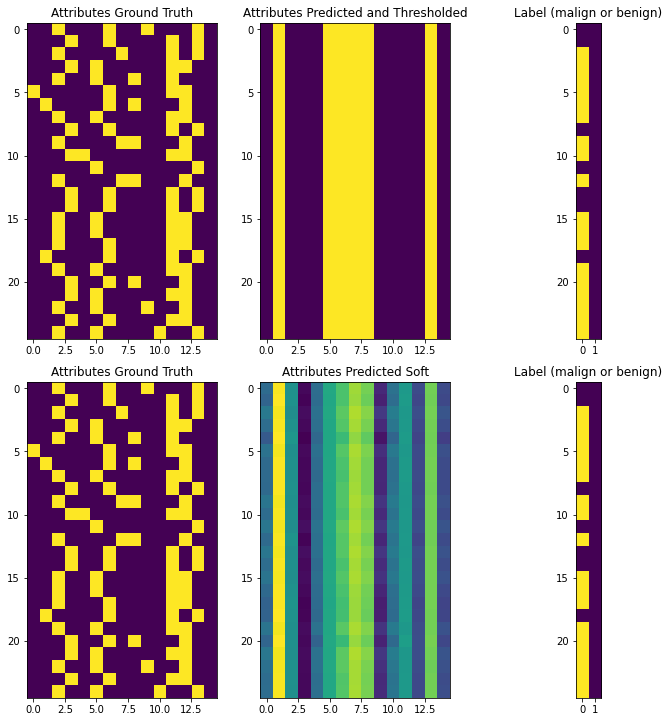

In [134]:
## ALL this should be on TEST set
# Visualizing the results for attributes and labels
attr_pred = np.squeeze(np.array(attr_pred))
attr_gt = np.squeeze(np.array(attr_gt))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(231)    # The big subplot
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


ax1.imshow(attr_gt)
ax1.set_title("Attributes Ground Truth")
ax2.imshow((attr_pred > 0.5) * 1)
ax2.set_title("Attributes Predicted and Thresholded")

ax3.imshow(viz)
ax3.set_title("Label (malign or benign)")

ax4.imshow(attr_gt)
ax4.set_title("Attributes Ground Truth")
ax5.imshow(attr_pred )
ax5.set_title("Attributes Predicted Soft")

ax6.imshow(viz)
ax6.set_title("Label (malign or benign)")


plt.tight_layout(pad=0.6, w_pad=0, h_pad=1.0)


Text(0.5, 0, 'Attribute probability')

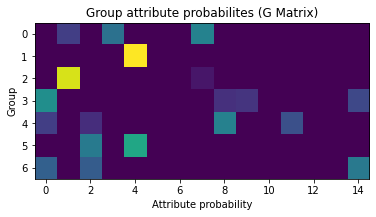

In [135]:
# Visualizing G matrix
plt.imshow(model.G_.data.detach().cpu().numpy())
plt.title("Group attribute probabilites (G Matrix)")
plt.ylabel("Group")
plt.xlabel("Attribute probability")

Text(0.5, 0, 'W values')

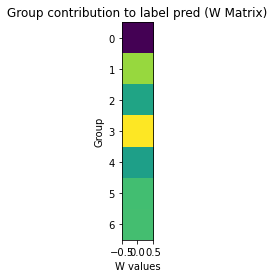

In [136]:
# Visualizing W Matrix
plt.imshow(model.W_.data.detach().cpu().numpy())
plt.title("Group contribution to label pred (W Matrix)")
plt.ylabel("Group")
plt.xlabel("W values")

In [93]:
# Legacy CAM code
# class CamExtractor():
#     """
#         Extracts cam features from the model
#     """
#     def __init__(self, model, target_layer):
#         self.model = model
#         self.target_layer = target_layer
        

#     def forward_pass_on_convolutions(self, x):
#         """
#             Does a forward pass on convolutions, hooks the function at given layer
#         """
#         conv_output = None
#         module_pos = 1
#         for module in self.model.features:
#             x = model.pool(module(x))  # Forward
#             if int(module_pos) == self.target_layer:
#                 conv_output = x  # Save the convolution output on that layer
#             module_pos += 1
#         return conv_output, x

#     def forward_pass(self, x):
#         """
#             Does a full forward pass on the model
#         """
#         conv_output, _ = self.forward_pass_on_convolutions(x)
#         x = F.interpolate(x, (300, 300), mode='bilinear')
#         (x_, _) = model(x)
#         return conv_output, x_

    
# extractor = CamExtractor(model, 4)

# count = 0
# for data in test_generator:
#     y_im_test = data["labels"][:, 15].to(device)
#     x_im_test = data["image"]
#     x_im_test = x_im_test.to(device)


#     [conv_out, x] = extractor.forward_pass_on_convolutions(x_im_test)
#     target = conv_out
#     cam = np.ones((target.shape[1:]), dtype=np.float32)
#     sal_map = np.zeros((224, 224))
#     for i in range(np.shape(target)[1]):
#                 # Unsqueeze to 4D
#                 saliency_map = torch.unsqueeze(torch.unsqueeze(target[0, i, :, :],0),0)
#                 # Upsampling to input size
#                 saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
#                 if saliency_map.max() == saliency_map.min():
#                     continue
#                 # Scale between 0-1
#                 norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
#                 inim = F.interpolate(x_im_test, size=(224, 224), mode='bilinear')
#                 w = extractor.forward_pass(inim * norm_saliency_map)[1]
#                 sal_map += w.cpu().data.numpy() * norm_saliency_map.cpu().data.numpy()[0, 0, :, :]
#                 cam += w.cpu().data.numpy() * target[0, i, :, :].cpu().data.numpy()


#     fig = plt.figure(figsize=(15, 10))

#     ax0 = fig.add_subplot(131)
#     ax0.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))

#     ax1 = fig.add_subplot(132)
#     ax1.imshow(sal_map)

#     ax2 = fig.add_subplot(133)
#     ax2.imshow(cam[0, :, :])
#     count += 1
#     if(count == 10):
#         break


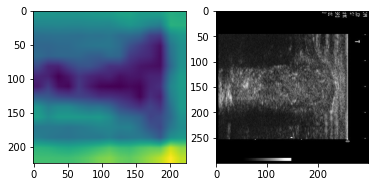

In [56]:
# Legacy CAM code
# fig = plt.figure()
# ax0 = fig.add_subplot(121)
# ax0.imshow(sal_map)

# ax1 = fig.add_subplot(122)
# ax1.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))



In [137]:
#Sankey plot code for G matrix
source = [i % a for i in range(z*a)]
target = [(i // 15) + 15 for i in range(z*a)]
G[G < 0.1] = 0.0
value = G.flatten().tolist()
#print(len(source), len(target), len(value))

color_node = [
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#FF0000', '#FFFF00', '#00FF00', '#00FFFF', '#FF00FF',
              '#00CED1', '#FF8C00', '#BDB76B', '#2F4F4F', '#B8860B'
              ]

color_link = []
link_colors = ['#F08080', '#FFFACD', '#98FB98', '#87CEFA', '#EE82EE',
              '#AFEEEE', '#FFA500', '#F0E68C', '#708090', '#DAA520']

In [138]:
for i in range(z):
    color_link.extend([link_colors[i]] * a)
#print(color_link)
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      color = color_node,
      label = ["cystic", "mostly solid", "solid", "spongiform",
               "hyper", "hypo", "iso", "marked",
               "ill-defined", "micro", "spiculated", "smooth",
               "macro", "micro", "non",
               "G1", "G2", "G3", "G4", "G5",
               "G6", "G7", "G8", "G9", "G10"],
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = color_link
  ))])
fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()